In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def set_plot_config(small_size=10, medium_size=14, big_size=16, usetex=False):
    sns.set_context("paper", font_scale=0.75)
    sns.set_palette(sns.color_palette("bright", 8))
    sns.set_style('white')

    rc = {
        'xtick.major.size': 2,
        'xtick.major.width': 0.5,
        'ytick.major.size': 2,
        'ytick.major.width': 0.5,
        'xtick.bottom': True,
        'ytick.left': True,
        'font.size': medium_size,
        'axes.titlesize': medium_size,
        'axes.labelsize': medium_size,
        'xtick.labelsize': small_size,
        'ytick.labelsize': small_size,
        'legend.fontsize': small_size,
        'figure.titlesize': medium_size,
        'savefig.dpi': 300,
        'figure.dpi': 300,
        'text.usetex': usetex,
        "font.family": "serif",
        "font.serif": ["Liberation Serif", "DejaVu Serif", 
                       "Nimbus Roman No9 L", "Times"]
    }

    plt.rcParams.update(rc)
    
def enable_jupyter_inline_backend():
    """
    启用 Jupyter inline 后端显示图像，并设置 bbox_inches 参数。
    仅在 Jupyter 环境下有效。
    """
    try:
        from IPython import get_ipython
        ipython = get_ipython()
        if ipython is not None:
            ipython.run_line_magic('matplotlib', 'inline')
            ipython.run_line_magic('config', "InlineBackend.print_figure_kwargs = {'bbox_inches': None}")
    except Exception as e:
        print("无法启用 Jupyter inline backend。错误信息: ", e)

In [8]:
set_plot_config()
enable_jupyter_inline_backend()

开始 FDM 迭代求解...
在 4674 次迭代后收敛。
计算耗时: 9.8814 秒

--- 模型验证 (中心点) ---
FDM 计算结果 T(0.5, 0.5) = 46.0082 °C
解析解结果   T(0.5, 0.5) = 46.0122 °C
绝对误差: 0.003970 °C

正在生成温度场可视化图像...


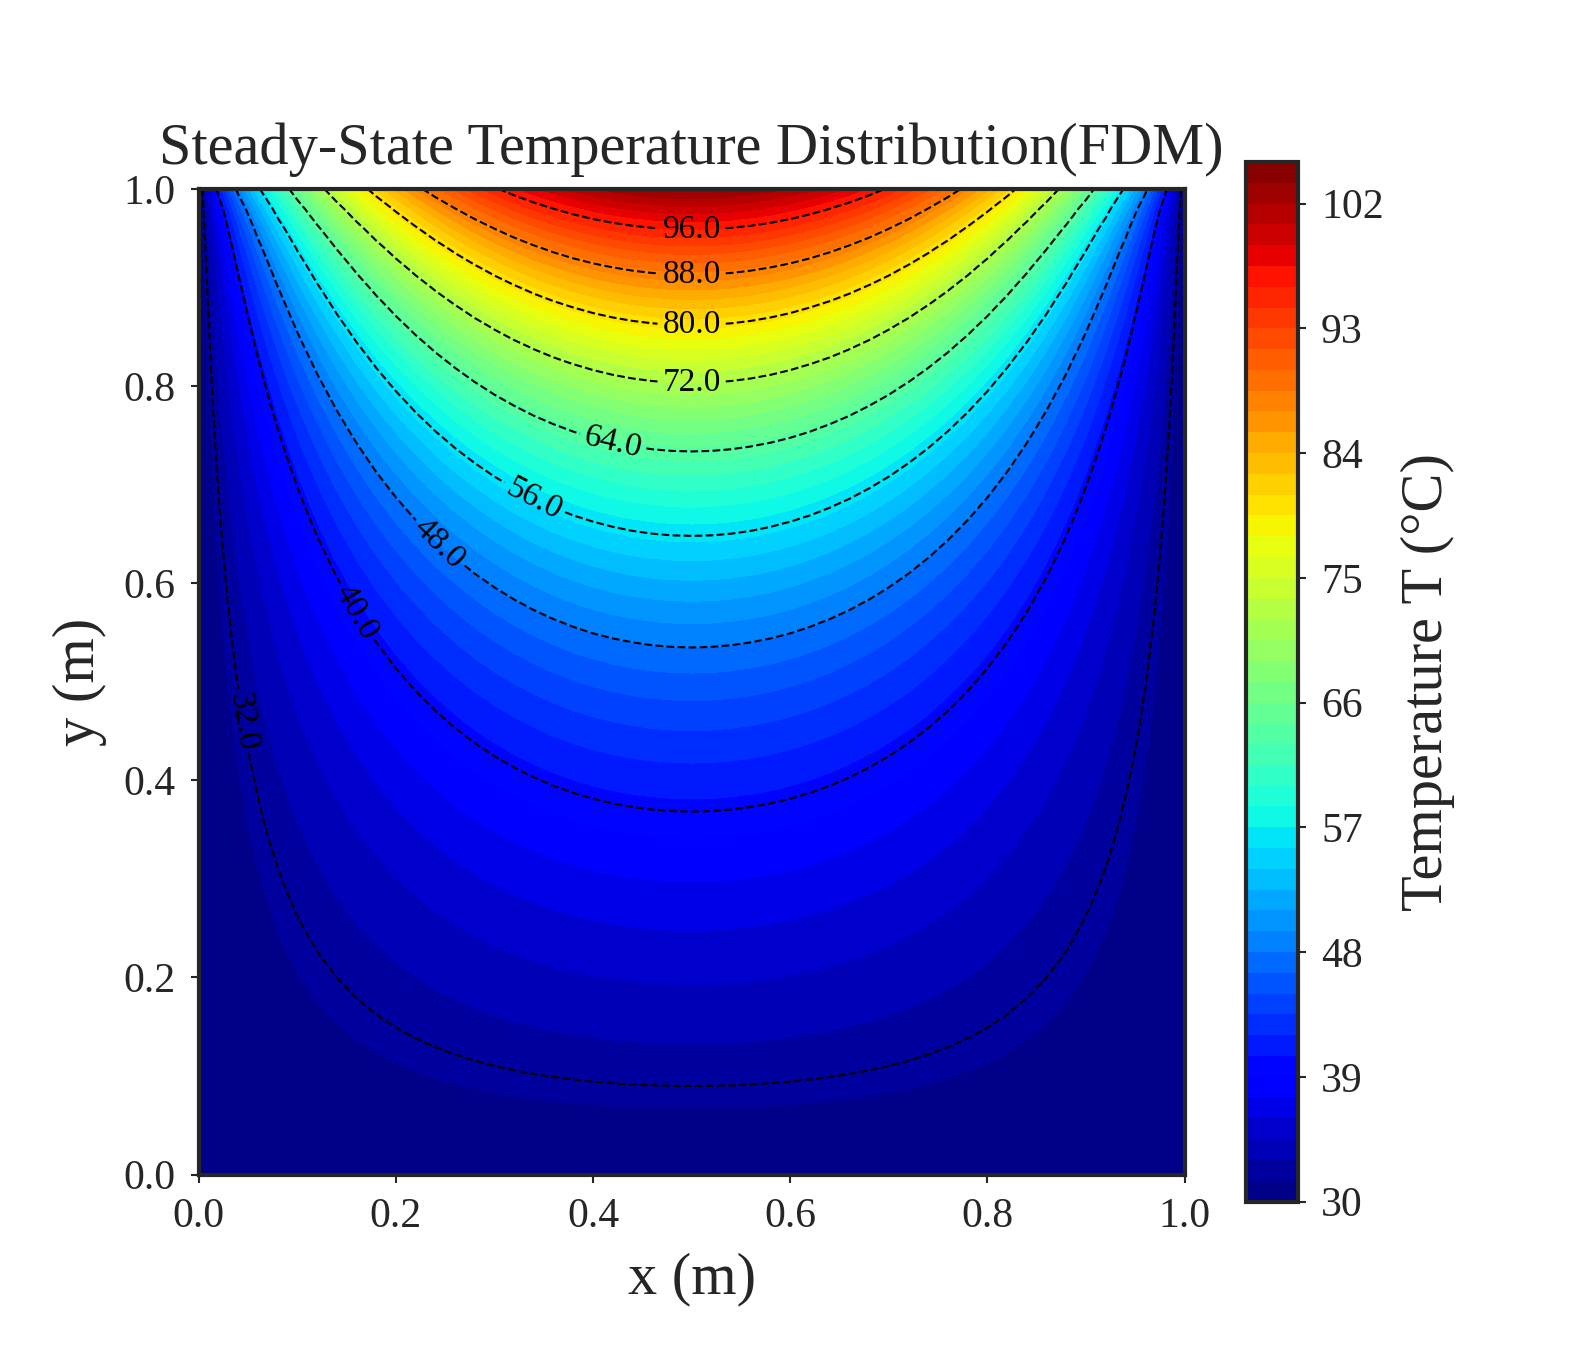

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time

# --- 1. 定义物理和数值参数 ---
# 物理参数 (来自作业 PDF)
L = 1.0         # 板的长度 (m) 
W = 1.0         # 板的宽度 (m) 
k = 10.0        # 热导率 (W/(m·K)) [cite: 6]
q_s_prime = 2000.0  # 热通量 (W/m^2) 
T1 = 30.0       # 恒定边界温度 (°C) [cite: 7]

# 数值参数 (用于 FDM)
Nx = 51         # x 方向的网格节点数 (奇数便于取中心点)
Ny = 51         # y 方向的网格节点数
dx = L / (Nx - 1)
dy = W / (Ny - 1)
if dx != dy:
    print("警告: 为获得最佳精度，建议使用 dx = dy。")

# 迭代控制参数
tolerance = 1e-6  # 收敛判据
max_iter = 10000    # 最大迭代次数

# --- 2. 初始化温度场 ---
# 创建 (Ny, Nx) 的网格，在 numpy 中索引为 (j, i) -> (y, x)
T = np.full((Ny, Nx), T1) # 初始猜测值（例如全部设为 T1）

# --- 3. 应用 Dirichlet 边界条件 ---
T[0, :] = T1   # 下边界 (y=0) [cite: 7]
T[:, 0] = T1   # 左边界 (x=0) [cite: 7]
T[:, -1] = T1  # 右边界 (x=L) [cite: 7]
# 注意：上边界 (y=W) 是通量边界，将在迭代中处理。
# 左右边界也固定了上边界的两个角点 (0, W) 和 (L, W) 为 T1。

# --- 4. 实施 FDM 迭代求解 (Gauss-Seidel) ---
start_time = time.time()
print("开始 FDM 迭代求解...")

# 预先计算通量项，避免在循环中重复计算
# (来自 (a) 问中对上边界的 FDM 推导)
flux_term = (2 * dy * q_s_prime) / k

for iteration in range(max_iter):
    T_old = T.copy()  # 保存上一步的温度场
    
    # 迭代内部节点 (i=1 到 Nx-2, j=1 到 Ny-2)
    for j in range(1, Ny - 1):
        for i in range(1, Nx - 1):
            T[j, i] = 0.25 * (T[j, i+1] + T[j, i-1] + T[j+1, i] + T[j-1, i])
            
    # 单独处理上边界 (y=W, j=Ny-1) 上的节点 (不包括角点)
    # T[j, i] = 0.25 * (T[j, i+1] + T[j, i-1] + 2*T[j-1, i] + flux_term)
    j = Ny - 1
    for i in range(1, Nx - 1):
        T[j, i] = 0.25 * (T[j, i+1] + T[j, i-1] + 2 * T[j-1, i] + flux_term)

    # 检查收敛性
    diff = np.max(np.abs(T - T_old))
    if diff < tolerance:
        print(f"在 {iteration + 1} 次迭代后收敛。")
        break
else:
    print(f"达到最大迭代次数 {max_iter}，未完全收敛。")

end_time = time.time()
print(f"计算耗时: {end_time - start_time:.4f} 秒")

# --- 5. 验证 (与解析解比较) ---
# (a) 问中推导的解析解
def T_analytical(x, y, N_terms=50):
    T_sum = 0
    # 仅对奇数 n 求和 (n = 1, 3, 5, ...)
    for n_odd in range(1, 2 * N_terms + 1, 2):
        term = (np.sin(n_odd * np.pi * x) * np.sinh(n_odd * np.pi * y)) / \
               (n_odd**2 * np.cosh(n_odd * np.pi))
        T_sum += term
    
    return T1 + (4 * q_s_prime) / (k * np.pi**2) * T_sum

# 比较中心点 T(L/2, W/2)
center_x = L / 2
center_y = W / 2
center_i = (Nx - 1) // 2
center_j = (Ny - 1) // 2

T_fdm_center = T[center_j, center_i]
T_ana_center = T_analytical(center_x, center_y)

print("\n--- 模型验证 (中心点) ---")
print(f"FDM 计算结果 T({center_x}, {center_y}) = {T_fdm_center:.4f} °C")
print(f"解析解结果   T({center_x}, {center_y}) = {T_ana_center:.4f} °C")
print(f"绝对误差: {np.abs(T_fdm_center - T_ana_center):.6f} °C")

# --- 6. 可视化稳态温度场 ---
print("\n正在生成温度场可视化图像...")

# 创建坐标网格
x = np.linspace(0, L, Nx)
y = np.linspace(0, W, Ny)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(5.3, 4.5))
# 绘制填充的等温线图
contour_filled = plt.contourf(X, Y, T, levels=50, cmap='jet')

# 添加颜色条
cbar = plt.colorbar(contour_filled)
cbar.set_label('Temperature T (°C)')

# 绘制等温线
contour_lines = plt.contour(X, Y, T, levels=10, colors='black', linestyles='dashed', linewidths=0.5)
plt.clabel(contour_lines, inline=1, fontsize=8, fmt='%.1f')

# 设置图像属性
plt.title('Steady-State Temperature Distribution(FDM)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().set_aspect('equal', adjustable='box') # 保持 1:1 的宽高比
plt.show()